## Imports

In [1193]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData, concat

import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from scipy import sparse, stats
from scipy.cluster import hierarchy
import pymn
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx


import re
import h5py

import itertools

import statsmodels.api as sm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from pathlib import Path

In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [5]:
sc.settings.verbosity = 3

In [6]:
import sys
sys.path.append('/home/bharris/pseudotime/scripts/')
from mn_utils import *

In [7]:
from move_seaborn_legend import move_legend
from egad import run_egad
import enrichment_stats

In [8]:
import mkl


mkl.set_num_threads(8)

48

## Functions

In [381]:
def read_nw(fn):
    f = h5py.File(fn)
    nw_genes = f['col'][:].astype(str)
    nw = f['agg'][:]
    f.close()
    return pd.DataFrame(nw, index=nw_genes,columns=nw_genes)

In [740]:
toupper = np.vectorize(lambda x: x.upper())
def get_conversion_table(species):
    return pd.read_csv(f'/tyrone-data/CoCoCoNet/geneInfo/{species}_info.csv')


def get_networkID(species,gene_list, flag='prio'):
    sets = ['NetworkIDs','EntrezID','GeneSymbol','EnsemblID','LocusTag']
    ctab = get_conversion_table(species)[sets]
    ctab_matches = ctab.apply(lambda x: np.in1d(toupper(x.astype(str)),toupper(gene_list)))
    selected_column = ctab_matches.sum().idxmax()
    assert ctab_matches[selected_column].sum() <= gene_list.shape[0], 'Matches must be less than or equal to gene list'
    results = ctab[ctab_matches[selected_column]].set_index(selected_column)
    results = results[~results.index.duplicated(keep='first')]
    results = results.reindex(gene_list).dropna(how='all')['NetworkIDs']
    if flag=='prio':
        f = h5py.File(f'/tyrone-data/CoCoCoNet/networks/{species}_{flag}AggNet.hdf5',
                            'r')
        allgenes = f['row'][:]

        results = results[np.in1d(results.values, allgenes.astype(str))]
        f.close()
    results.index = toupper(results.index)
    return results
def orthoMapper(speciesA, genes, speciesB):
    f1 = f'/tyrone-data/CoCoCoNet/orthologMaps/{speciesA}_{speciesB}_orthoNM.csv'
    f2 = f'/tyrone-data/CoCoCoNet/orthologMaps/{speciesB}_{speciesA}_orthoNM.csv'
    if Path(f1).exists():
        orthoDat = pd.read_csv(f1)
    elif Path(f2).exists():
        orthoDat = pd.read_csv(f2)
    else:
        print(f'Speices map does not exist : {speciesA} {speciesB}')
        print(f1)
        print(f2)
        return np.array(None)
    #Subset to individual genes
    genes = toupper(genes)
    one2one_matches = orthoDat[orthoDat[speciesA].isin(genes)].groupby(speciesA).size().to_frame(name='n_ortho').query('n_ortho==1').index
    a2b = orthoDat[orthoDat[speciesA].isin(one2one_matches)]

    return a2b.set_index(speciesA)[speciesB]

## Load Data

In [404]:
species_classification = pd.read_csv('/tyrone-data/suresh/species_classification_ranks.txt',delimiter='\t')

tmp = (species_classification[['Classification','Classification_rank']]
 .applymap(lambda x: x.split(','))
 .apply(lambda x : dict(zip(x.Classification_rank,x.Classification)),axis=1))
tmp.index = species_classification.Species

tmp = tmp.apply(pd.Series)
species_classification = pd.concat([species_classification.set_index('Species'),tmp],axis=1).drop(columns=['Classification','Classification_rank'])

species_classification['saved_name'] = species_classification.Common_name.apply(lambda x : x.lower())
species_classification.saved_name.replace({
                                           'medicago truncatula':'medicago',
                                           'purple false brome plant':'brome',
                                           'algae':'chlam',
                                           'silkworm':'bombyx',
                                           'yellow fever mosquito':'mosquito',
                                           'european honey bee': 'bee',
                                           'atlantic salmon':'atlanticsalmon',
                                           'rainbow trout': 'rainbowtrout',
                                           'western clawed frog':'wfrog',
                                          'european rabbit':'rabbit',
                                          'chimpanzee':'chimp',
                                          'rhesus macaque': 'rhesusm',
                                          'crab-eating macaque':'crabm',
                                          'field mustard':'mustard'},inplace=True)
species_classification = species_classification[species_classification.saved_name != 'african clawed frog']
species_classification.to_csv('/tyrone-data/bharris/species_classification_ranks_processed.txt')
species_classification

,Common_name,Tax_ID,superkingdom,kingdom,phylum,class,order,family,genus,species,saved_name
Species,,,,,,,,,,,
Arabidopsis thaliana,Arabidopsis,3702,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Brassicales,Brassicaceae,Arabidopsis,NaN,arabidopsis
Brassica rapa,Field mustard,3711,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Brassicales,Brassicaceae,Brassica,NaN,mustard
Glycine max,Soybean,3847,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Fabales,Fabaceae,Glycine,NaN,soybean
Medicago truncatula,Medicago truncatula,3880,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Fabales,Fabaceae,Medicago,NaN,medicago
Solanum lycopersicum,Tomato,4081,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Solanales,Solanaceae,Solanum,NaN,tomato
Solanum tuberosum,Potato,4113,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Solanales,Solanaceae,Solanum,NaN,potato
Nicotiana tabacum,Tobacco,4097,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Solanales,Solanaceae,Nicotiana,NaN,tobacco
Malus domestica,Apple,3750,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Rosales,Rosaceae,Malus,NaN,apple
Vitis vinifera,Grape,29760,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Vitales,Vitaceae,Vitis,NaN,grape


In [405]:
eryth_genes = np.genfromtxt('/home/bharris/pseudotime/data/monocle/gene_models/top_50_erythroid_genes_no_gaps.csv', 
                            dtype=str)
mono_genes = np.genfromtxt('/home/bharris/pseudotime/data/monocle/gene_models/top_50_monocyte_genes_no_gaps.csv', 
                            dtype=str)
erythroid_networkIDs = get_networkID('mouse',eryth_genes).values
monocyte_networkIDs = get_networkID('mouse',mono_genes).values

In [408]:
input_species = 'mouse'
dataDir = '/tyrone-data/CoCoCoNet/'

## Lineage Associated Genes

In [409]:
egad_results =  pd.DataFrame(index=species_classification.index)
for species in species_classification.index:
    print(species)
    if species =='mouse':
        continue
    saved_name = species_classification.saved_name[species]
    coexp = read_nw(f'{dataDir}/networks/{saved_name}_prioAggNet.hdf5')
    eryth_mapped = np.in1d(coexp.index, orthoMapper('mouse',erythroid_networkIDs,saved_name).values)
    mono_mapped = np.in1d(coexp.index, orthoMapper('mouse',monocyte_networkIDs,saved_name).values)
    geneLists = pd.DataFrame({'Erythroid':eryth_mapped,'Monocyte':mono_mapped},index=coexp.index)
    if geneLists.sum().max()<5:
        continue
    egad_res = run_egad(geneLists, coexp, min_count=4)
    for row in egad_res.index:
        egad_results.loc[species, f'{row}_AUROC'] = egad_res.loc[row,'AUC']
        egad_results.loc[species, f'{row}_ORTHOS'] = geneLists[row].sum()
    del coexp
    gc.collect()

#Do EGAD for Mouse
coexp = read_nw(f'{dataDir}/networks/mouse_prioAggNet.hdf5')
eryth_mapped = np.in1d(coexp.index, erythroid_networkIDs)
mono_mapped = np.in1d(coexp.index, monocyte_networkIDs)
geneLists = pd.DataFrame({'Erythroid':eryth_mapped,'Monocyte':mono_mapped},index=coexp.index)
mouse_egad = run_egad(geneLists, coexp)
del coexp
gc.collect()

egad_results.loc['Mus musculus', 'Erythroid_AUROC'] = mouse_egad.loc['Erythroid','AUC']
egad_results.loc['Mus musculus', 'Monocyte_AUROC'] = mouse_egad.loc['Monocyte','AUC']
egad_results.loc['Mus musculus', 'Monocyte_ORTHOS'] = 50
egad_results.loc['Mus musculus', 'Erythroid_ORTHOS'] = 50

egad_res_filter = egad_results.dropna(thresh=3)


egad_res_filter = pd.concat([egad_res_filter,species_classification],axis=1).dropna(thresh=12)

egad_res_filter['AVG_ORTHOS'] = (egad_res_filter.Monocyte_ORTHOS + egad_res_filter.Erythroid_ORTHOS) / 2

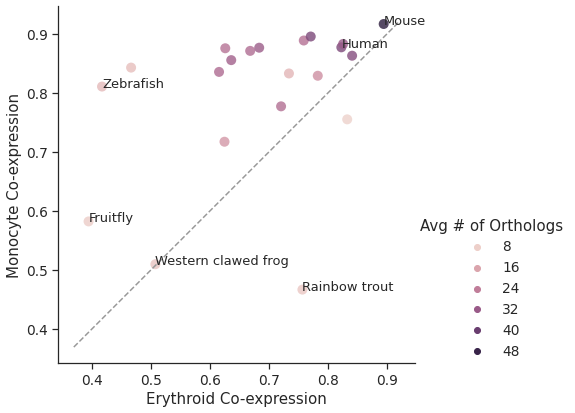

In [1273]:
fig, ax = plt.subplots(figsize=(9,6))
sns.scatterplot(data=egad_res_filter,
                x='Erythroid_AUROC',
                y='Monocyte_AUROC',
                hue='AVG_ORTHOS',
                edgecolor='none',
                linewidth=0,
                vmin=0,
                vmax=50,
                s=100,
                alpha=.8,
                ax=ax)
for species in ['Homo sapiens', 'Danio rerio', 'Mus musculus','Drosophila melanogaster','Oncorhynchus mykiss','Xenopus tropicalis']:
    ax.text(egad_res_filter.loc[species,'Erythroid_AUROC'],
            egad_res_filter.loc[species,'Monocyte_AUROC'],
            egad_res_filter.loc[species,'Common_name'],
           fontsize=13)
ax.legend(loc=(1,0),frameon=False,title='Avg # of Orthologs')
ax.plot(ax.get_xlim(),ax.get_xlim(),ls='--',c='.6')
ax.set(xlabel='Erythroid Co-expression',ylabel='Monocyte Co-expression',aspect='equal')
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/cross_species/cococoNet_egad_lineage.pdf',
            transparent=True)

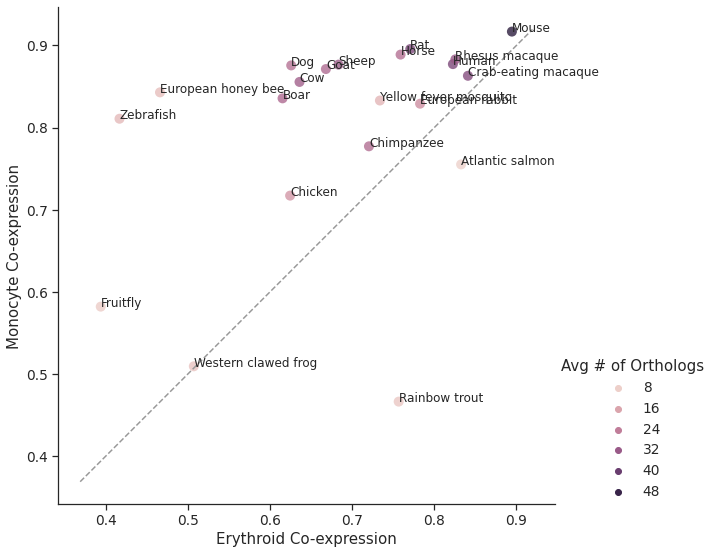

In [1985]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=egad_res_filter,
                x='Erythroid_AUROC',
                y='Monocyte_AUROC',
                hue='AVG_ORTHOS',
                edgecolor='none',
                linewidth=0,
                vmin=0,
                vmax=50,
                s=100,
                alpha=.8,
                ax=ax)
for species in egad_res_filter.index:
    ax.text(egad_res_filter.loc[species,'Erythroid_AUROC'],
            egad_res_filter.loc[species,'Monocyte_AUROC'],
            egad_res_filter.loc[species,'Common_name'],
           fontsize=12)
ax.legend(loc=(1,0),frameon=False,title='Avg # of Orthologs')
ax.plot(ax.get_xlim(),ax.get_xlim(),ls='--',c='.6')
ax.set(xlabel='Erythroid Co-expression',ylabel='Monocyte Co-expression',aspect='equal')
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/cross_species/cococoNet_egad_lineage_all_species.pdf',
            transparent=True)

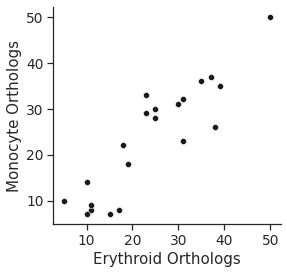

In [517]:
ax=sns.scatterplot(data=egad_res_filter,
                   x='Erythroid_ORTHOS',
                   y='Monocyte_ORTHOS',
                   color='k')
ax.set(aspect='equal',xlabel='Erythroid Orthologs',ylabel='Monocyte Orthologs')

plt.show()

## Zebrafish scRNAseq Data

In [1050]:
zebrafish = pd.read_csv('/data/bharris/single_cell_data/liu/GSM3402061_zebrafish_HSC_counts_change.merge.txt',
                        delimiter='\t').groupby('gene').sum()

zebra_adata = sc.AnnData(sparse.csr_matrix(zebrafish.values.T))

zebra_adata.obs_names = zebrafish.columns
zebra_adata.var_names = zebrafish.index


sc.pp.calculate_qc_metrics(zebra_adata, inplace=True, percent_top=None)

In [1051]:
#This is based on the manuscript
sc.pp.filter_cells(zebra_adata, min_genes=800)
sc.pp.filter_cells(zebra_adata, max_genes=4000)


filtered out 55 cells that have less than 800 genes expressed
filtered out 32 cells that have more than 4000 genes expressed


In [1052]:
sc.pp.normalize_total(zebra_adata)
sc.pp.log1p(zebra_adata)
sc.pp.highly_variable_genes(zebra_adata)
sc.pp.pca(zebra_adata)
sc.pp.neighbors(zebra_adata)
sc.tl.umap(zebra_adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [1053]:
liu_markers = pd.read_excel('/data/bharris/single_cell_data/liu/mmc5.xlsx',skiprows=1,index_col='gene')

#liu_markers.index = toupper(liu_markers.index)

liu_submarkers = pd.read_excel('/data/bharris/single_cell_data/liu/mmc6.xlsx',skiprows=1)

for subgroup in liu_submarkers.columns:
    sc.tl.score_genes(zebra_adata, liu_submarkers[subgroup].dropna().values,score_name=subgroup.split('(')[1][:-1])

for tsne_group in liu_markers['TSNE-Group'].unique():
    group_markers = liu_markers.query('avg_logFC> 1 & p_val_adj<.001 & `TSNE-Group` == @tsne_group')
    sc.tl.score_genes(zebra_adata, group_markers.index, score_name=f'GROUP_{tsne_group}')
zebra_adata.obs['top_group'] = zebra_adata.obs.filter(regex='GROUP').idxmax(axis=1)
zebra_adata.obs['top_progenitor'] = zebra_adata.obs.filter(regex='progenitors').idxmax(axis=1)
zebra_adata.obs['top_group_score'] = zebra_adata.obs.filter(regex='GROUP').max(axis=1)
zebra_adata.obs['top_progenitor_score'] = zebra_adata.obs.filter(regex='progenitors').max(axis=1)

computing score 'lympoid progenitors'
    finished: added
    'lympoid progenitors', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'erythorid megakaryocyte progenitors'
    finished: added
    'erythorid megakaryocyte progenitors', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'myeloid progenitors'
    finished: added
    'myeloid progenitors', score of gene set (adata.obs).
    248 total control genes are used. (0:00:00)
computing score 'HSPC/progenitors'
    finished: added
    'HSPC/progenitors', score of gene set (adata.obs).
    496 total control genes are used. (0:00:00)
computing score 'erythrocytes'
    finished: added
    'erythrocytes', score of gene set (adata.obs).
    347 total control genes are used. (0:00:00)
computing score 'GROUP_0'
    finished: added
    'GROUP_0', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score 'GROUP_1'
  

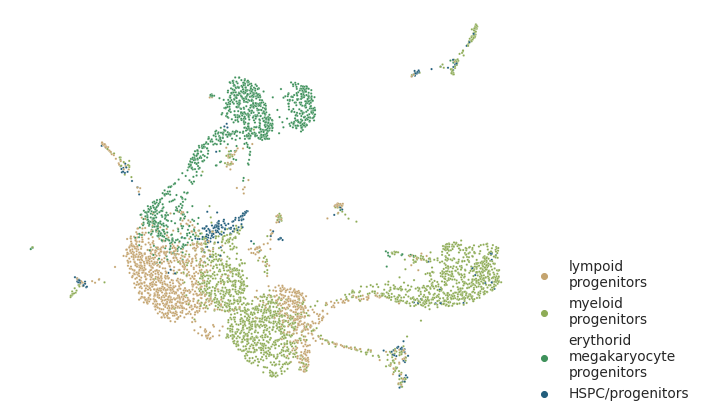

In [1988]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=zebra_adata.obsm['X_umap'][:,0],
                y=zebra_adata.obsm['X_umap'][:,1],
               hue=[x.replace(' ','\n') for x in zebra_adata.obs.top_progenitor],
               s=5,
               ax=ax,
               palette='gist_earth_r')
ax.legend(loc=(1,0),
          frameon=False)
ax.axis('off')
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/cross_species/zebrafish_estimated_cell_type.pdf',
            transparent=True)

In [1060]:
zebra_networkIDs = get_networkID('zebrafish', zebra_adata.var_names)

zebra_adata.var = zebra_networkIDs.reindex(toupper(zebra_adata.var_names)).to_frame()

In [1061]:
zebra_adata_NetworkIDs = zebra_adata[:,~zebra_adata.var.NetworkIDs.isna()]
zebra_adata_NetworkIDs.var_names = zebra_adata_NetworkIDs.var.NetworkIDs
zebra_adata_NetworkIDs.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [1064]:
sc.tl.score_genes(zebra_adata_NetworkIDs,zebra_erythroid,score_name='Erythroid_lineage')
sc.tl.score_genes(zebra_adata_NetworkIDs,zebra_monocyte,score_name='Monocyte_lineage')

for ct in top_markers.columns:
    mouse_genes = top_markers.index[top_markers[ct].astype(bool)]
    zebra_converted_genes = np.intersect1d(orthoMapper('mouse',mouse_genes,'zebrafish'),zebra_adata_NetworkIDs.var_names)
    assert(zebra_converted_genes.shape[0]>0)
    sc.tl.score_genes(zebra_adata_NetworkIDs, zebra_converted_genes, score_name=ct)

computing score 'Erythroid_lineage'
    finished: added
    'Erythroid_lineage', score of gene set (adata.obs).
    398 total control genes are used. (0:00:00)
computing score 'Monocyte_lineage'
    finished: added
    'Monocyte_lineage', score of gene set (adata.obs).
    399 total control genes are used. (0:00:00)
computing score 'T cell'
    finished: added
    'T cell', score of gene set (adata.obs).
    350 total control genes are used. (0:00:00)
computing score 'basophil'
    finished: added
    'basophil', score of gene set (adata.obs).
    299 total control genes are used. (0:00:00)
computing score 'erythroblast'
    finished: added
    'erythroblast', score of gene set (adata.obs).
    499 total control genes are used. (0:00:00)
computing score 'granulocyte'
    finished: added
    'granulocyte', score of gene set (adata.obs).
    448 total control genes are used. (0:00:00)
computing score 'hematopoietic precursor cell'
    finished: added
    'hematopoietic precursor cell', s

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to b

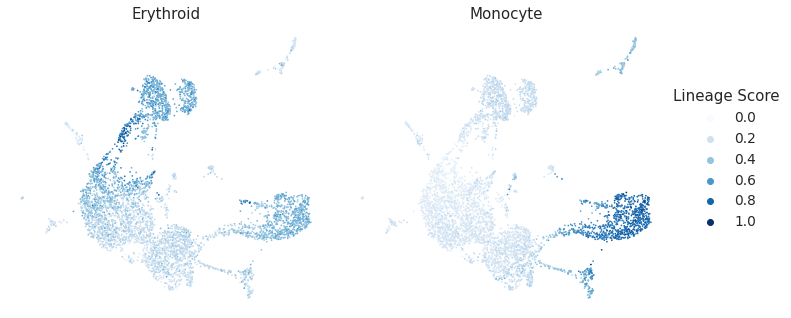

In [2029]:
df = zebra_adata_NetworkIDs.obs[['Erythroid_lineage','Monocyte_lineage']]
df['UMAP1'] = zebra_adata_NetworkIDs.obsm['X_umap'][:,0]
df['UMAP2'] = zebra_adataNetworkIDs.obsm['X_umap'][:,1]

df.Erythroid_lineage += np.abs(df.Erythroid_lineage.min())
df.Erythroid_lineage /= df.Erythroid_lineage.max()

df.Monocyte_lineage += np.abs(df.Monocyte_lineage.min())
df.Monocyte_lineage /= df.Monocyte_lineage.max()

g = sns.relplot(data=df.melt(id_vars=['UMAP1','UMAP2'],var_name='Lineage',value_name='Lineage Score'),
            x='UMAP1',
            y='UMAP2',
            hue='Lineage Score',
            col='Lineage',
            edgecolor='none',
            linewidth=0,
            s=3,
            palette='Blues')
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    ax.set(title=study.split('_')[0])

g.savefig('/home/bharris/pseudotime/figures/cross_species/zebrafish_lineage_scores_umap.pdf',
          transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to b

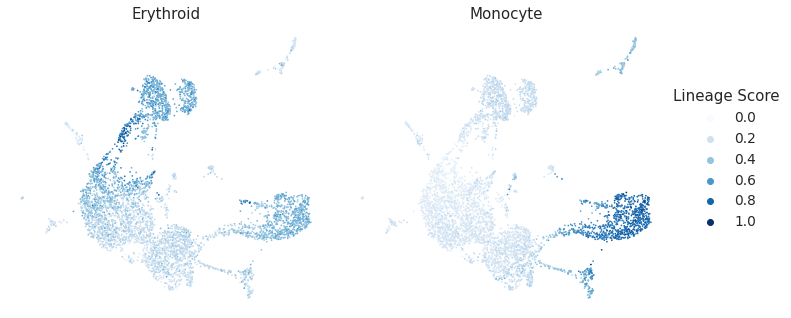

In [2067]:
df = zebra_adata_NetworkIDs.obs[['Erythroid_lineage','Monocyte_lineage']]
df['UMAP1'] = zebra_adata_NetworkIDs.obsm['X_umap'][:,0]
df['UMAP2'] = zebra_adata_NetworkIDs.obsm['X_umap'][:,1]

df.Erythroid_lineage += np.abs(df.Erythroid_lineage.min())
df.Erythroid_lineage /= df.Erythroid_lineage.max()

df.Monocyte_lineage += np.abs(df.Monocyte_lineage.min())
df.Monocyte_lineage /= df.Monocyte_lineage.max()

g = sns.relplot(data=df.melt(id_vars=['UMAP1','UMAP2'],var_name='Lineage',value_name='Lineage Score'),
            x='UMAP1',
            y='UMAP2',
            hue='Lineage Score',
            col='Lineage',
            edgecolor='none',
            linewidth=0,
            s=3,
            palette='Blues')
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    ax.set(title=study.split('_')[0])

g.savefig('/home/bharris/pseudotime/figures/cross_species/zebrafish_lineage_scores_umap_blues.pdf',
          transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to b

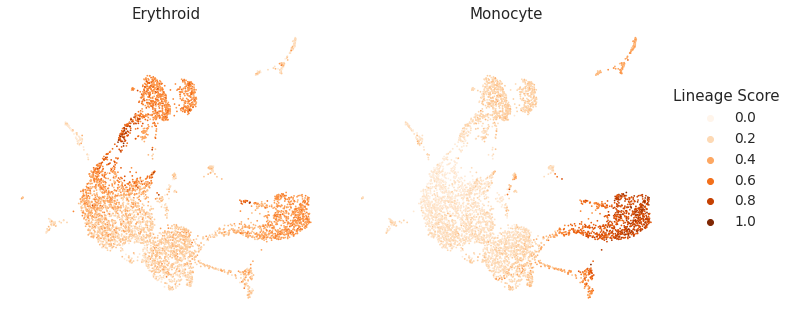

In [2069]:
df = zebra_adata_NetworkIDs.obs[['Erythroid_lineage','Monocyte_lineage']]
df['UMAP1'] = zebra_adata_NetworkIDs.obsm['X_umap'][:,0]
df['UMAP2'] = zebra_adata_NetworkIDs.obsm['X_umap'][:,1]

df.Erythroid_lineage += np.abs(df.Erythroid_lineage.min())
df.Erythroid_lineage /= df.Erythroid_lineage.max()

df.Monocyte_lineage += np.abs(df.Monocyte_lineage.min())
df.Monocyte_lineage /= df.Monocyte_lineage.max()

g = sns.relplot(data=df.melt(id_vars=['UMAP1','UMAP2'],var_name='Lineage',value_name='Lineage Score'),
            x='UMAP1',
            y='UMAP2',
            hue='Lineage Score',
            col='Lineage',
            edgecolor='none',
            linewidth=0,
            s=3,
            palette='Oranges')
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    ax.set(title=study.split('_')[0])

g.savefig('/home/bharris/pseudotime/figures/cross_species/zebrafish_lineage_scores_umap_oranges.pdf',
          transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to b

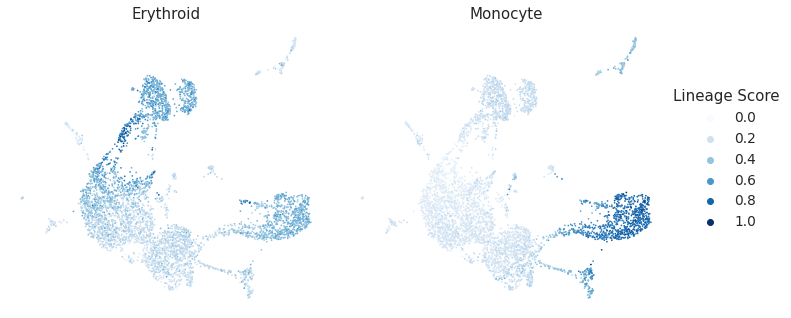

In [2029]:
df = zebra_adata_NetworkIDs.obs[['Erythroid_lineage','Monocyte_lineage']]
df['UMAP1'] = zebra_adata_NetworkIDs.obsm['X_umap'][:,0]
df['UMAP2'] = zebra_adataNetworkIDs.obsm['X_umap'][:,1]

df.Erythroid_lineage += np.abs(df.Erythroid_lineage.min())
df.Erythroid_lineage /= df.Erythroid_lineage.max()

df.Monocyte_lineage += np.abs(df.Monocyte_lineage.min())
df.Monocyte_lineage /= df.Monocyte_lineage.max()

g = sns.relplot(data=df.melt(id_vars=['UMAP1','UMAP2'],var_name='Lineage',value_name='Lineage Score'),
            x='UMAP1',
            y='UMAP2',
            hue='Lineage Score',
            col='Lineage',
            edgecolor='none',
            linewidth=0,
            s=3,
            palette='Blues')
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    ax.set(title=study.split('_')[0])

g.savefig('/home/bharris/pseudotime/figures/cross_species/zebrafish_lineage_scores_umap_blues.pdf',
          transparent=True)

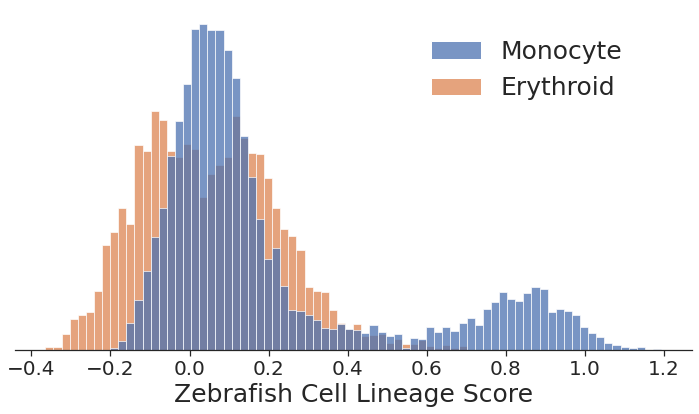

In [2083]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=(zebra_adata_NetworkIDs
                        .obs[['Erythroid_lineage','Monocyte_lineage']]
                        .rename(columns={'Erythroid_lineage':'Erythroid',
                                         'Monocyte_lineage':'Monocyte'})),
                 hue_order=['Monocyte','Erythroid'],
            ax=ax)
move_legend(ax, (.6,.7),frameon=False, fontsize=25)
ax.set(yticks=[],ylabel='')
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel('Zebrafish Cell Lineage Score', fontsize=25)
ax.yaxis.set_visible(False) 
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/cross_species/zebrafish_lineage_scores_hist.pdf',
            transparent=True)

In [1075]:
zebra_adata_NetworkIDs.obs['top_ortholog'] = zebra_adata_NetworkIDs.obs[top_markers.columns].idxmax(axis=1)
zebra_adata_NetworkIDs.obs['top_ortholog_score'] = zebra_adata_NetworkIDs.obs[top_markers.columns].max(axis=1)

## Human scRNAseq Data

In [1216]:
def load_human(fn):
    df = pd.read_csv(fn,delimiter='\t',index_col=0).T
    ct = fn.split('/')[-1].split('.')[0].split('_')[1]
    df['Cell Type'] = ct
    donorB_Cts = ['LinNegCD34PosCD164Pos', 'LinNegCD34NegCD164high','LinNegCD34lowCD164high', 'LinNegCD34NegCD164low']
    df['Donor'] = 'DonorB' if ct in donorB_Cts else 'DonorA'
    return df

In [1217]:
human_hsc = load_human('/data/bharris/single_cell_data/pellin/GSM3305359_HSC.raw_counts.tsv.gz')
human_mpp = load_human('/data/bharris/single_cell_data/pellin/GSM3305360_MPP.raw_counts.tsv.gz')
human_mlp = load_human('/data/bharris/single_cell_data/pellin/GSM3305361_MLP.raw_counts.tsv.gz')
human_prebnk = load_human('/data/bharris/single_cell_data/pellin/GSM3305362_PreBNK.raw_counts.tsv.gz')
human_mep = load_human('/data/bharris/single_cell_data/pellin/GSM3305363_MEP.raw_counts.tsv.gz')
human_cmp = load_human('/data/bharris/single_cell_data/pellin/GSM3305364_CMP.raw_counts.tsv.gz')
human_gmp = load_human('/data/bharris/single_cell_data/pellin/GSM3305365_GMP.raw_counts.tsv.gz')
human_34Pos164Pos  = load_human('/data/bharris/single_cell_data/pellin/GSM3305366_LinNegCD34PosCD164Pos.raw_counts.tsv.gz')
human_34Neg164high = load_human('/data/bharris/single_cell_data/pellin/GSM3305367_LinNegCD34NegCD164high.raw_counts.tsv.gz')
human_34low164high = load_human('/data/bharris/single_cell_data/pellin/GSM3305368_LinNegCD34lowCD164high.raw_counts.tsv.gz')
human_34Neg164low = load_human('/data/bharris/single_cell_data/pellin/GSM3305369_LinNegCD34NegCD164low.raw_counts.tsv.gz')


In [1218]:
all_human = pd.concat([human_hsc,
human_mpp,
human_mlp,
human_prebnk,
human_mep,
human_cmp,
human_gmp,
human_34Pos164Pos,
human_34Neg164high,
human_34low164high,
human_34Neg164low])

In [1219]:
human_library_1 = all_human.query('Library==1').dropna(axis=1)
genes = human_library_1.drop(columns=['Library','Cell Type','Donor']).columns

human_library_1 = sc.AnnData(sparse.csr_matrix(human_library_1.drop(columns=['Library','Cell Type','Donor']).dropna(axis=1).values),
           obs=human_library_1[['Cell Type','Donor']])
human_library_1.obs_names_make_unique()
human_library_1.var_names = genes

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [1220]:

donorA = human_library_1[~human_library_1.obs['Cell Type'].isin(donorB_Cts)]
donorB = human_library_1[human_library_1.obs['Cell Type'].isin(donorB_Cts)]

### All DonorB

In [1318]:
donorB_all = all_human[all_human.Donor=='DonorB'].dropna(axis=1)
donorB_meta = donorB_all[['Cell Type','Library','Donor']]
donorB_genes = donorB_all.columns[~donorB_all.columns.isin(['Cell Type','Library','Donor'])]
donorB_all = sc.AnnData(sparse.csr_matrix(donorB_all.drop(columns=['Cell Type','Library','Donor']).values),
           obs=donorB_meta)
donorB_all.var_names= donorB_genes
donorB_all.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [1319]:
sc.pp.calculate_qc_metrics(donorB_all,percent_top=None, inplace=True)
sc.pp.normalize_total(donorB_all)
sc.pp.log1p(donorB_all)
sc.pp.highly_variable_genes(donorB_all)
sc.pp.pca(donorB_all)
sc.pp.neighbors(donorB_all)
sc.tl.umap(donorB_all)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


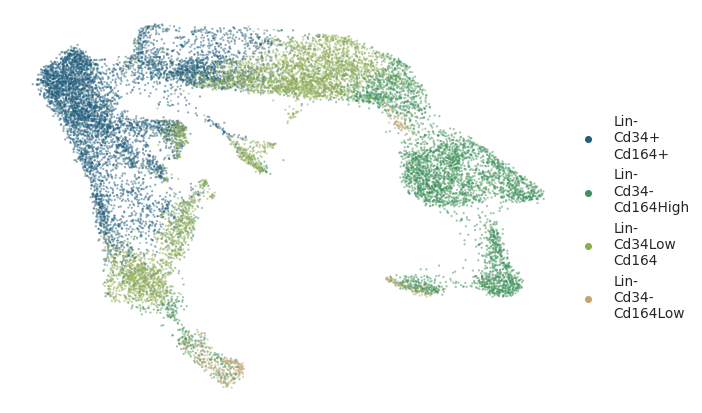

In [1384]:
tsl_labels = pd.Series({'LinNegCD34PosCD164Pos':'Lin-\nCd34+\nCd164+', 
 'LinNegCD34NegCD164high':'Lin-\nCd34-\nCd164High',
 'LinNegCD34lowCD164high':'Lin-\nCd34Low\nCd164', 
 'LinNegCD34NegCD164low':'Lin-\nCd34-\nCd164Low'})

fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=donorB_all.obsm['X_umap'][:,0],
            y=donorB_all.obsm['X_umap'][:,1],
               hue=tsl_labels[donorB_all.obs['Cell Type']],
               edgecolor='none',
               palette='gist_earth',
               s=5,
               alpha=.5,
               ax=ax)
ax.legend(loc=(1,.2),
          frameon=False)
ax.axis('off')
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/cross_species/humam_umap_facs_labels.pdf',
            transparent=True)

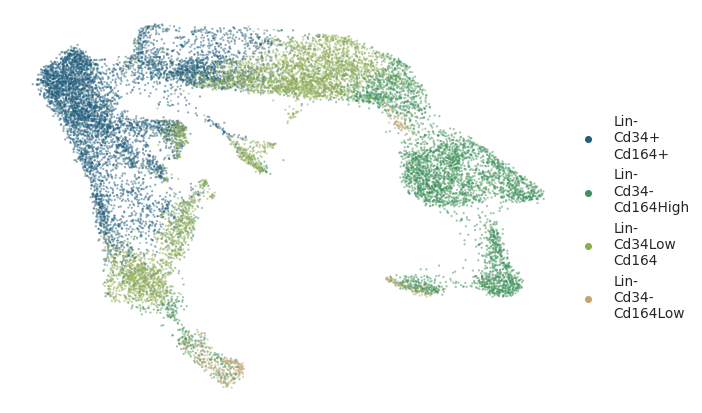

In [2084]:
tsl_labels = pd.Series({'LinNegCD34PosCD164Pos':'Lin-\nCd34+\nCd164+', 
 'LinNegCD34NegCD164high':'Lin-\nCd34-\nCd164High',
 'LinNegCD34lowCD164high':'Lin-\nCd34Low\nCd164', 
 'LinNegCD34NegCD164low':'Lin-\nCd34-\nCd164Low'})

fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=donorB_all.obsm['X_umap'][:,0],
            y=donorB_all.obsm['X_umap'][:,1],
               hue=tsl_labels[donorB_all.obs['Cell Type']],
               edgecolor='none',
               palette='gist_earth',
               s=5,
               alpha=.5,
               ax=ax)
ax.legend(loc=(1,.2),
          frameon=False)
ax.axis('off')
plt.tight_layout()
plt.savefig('/tyrone-data/bharris/for_john/human_umap_facs_labels.png',
            transparent=True)

In [2087]:
donorB_all.write_loom('/tyrone-data/bharris/for_john/human_scRNAseq_data.loom', write_obsm_varm=True)
donorB_all.write_h5ad('/tyrone-data/bharris/for_john/human_scRNAseq_data.h5ad')

In [1325]:
human_networkIDs = get_networkID('human', donorB_all.var_names)

donorB_all.var = human_networkIDs.reindex(toupper(donorB_all.var_names)).to_frame()

In [1326]:
donorB_all_NetworkIDs = donorB_all[:,~donorB_all.var.NetworkIDs.isna()]
donorB_all_NetworkIDs.var_names = donorB_all_NetworkIDs.var.NetworkIDs
donorB_all_NetworkIDs.var_names_make_unique()

In [1386]:
human_erythroid = np.intersect1d(orthoMapper('mouse',erythroid_networkIDs,'human'),donorB_all_NetworkIDs.var_names)
human_monocyte = np.intersect1d(orthoMapper('mouse',monocyte_networkIDs,'human'),donorB_all_NetworkIDs.var_names)
sc.tl.score_genes(donorB_all_NetworkIDs, human_erythroid, score_name='Erythroid_lineage')
sc.tl.score_genes(donorB_all_NetworkIDs, human_monocyte, score_name='Monocyte_lineage')


for ct in top_markers.columns:
    mouse_genes = top_markers.index[top_markers[ct].astype(bool)]
    human_converted_genes = np.intersect1d(orthoMapper('mouse',mouse_genes,'human'),donorB_all_NetworkIDs.var_names)
    assert(human_converted_genes.shape[0]>0)
    sc.tl.score_genes(donorB_all_NetworkIDs, human_converted_genes, score_name=ct)

computing score 'Erythroid_lineage'
    finished: added
    'Erythroid_lineage', score of gene set (adata.obs).
    699 total control genes are used. (0:00:00)
computing score 'Monocyte_lineage'
    finished: added
    'Monocyte_lineage', score of gene set (adata.obs).
    849 total control genes are used. (0:00:00)
computing score 'T cell'
    finished: added
    'T cell', score of gene set (adata.obs).
    850 total control genes are used. (0:00:00)
computing score 'basophil'
    finished: added
    'basophil', score of gene set (adata.obs).
    748 total control genes are used. (0:00:00)
computing score 'erythroblast'
    finished: added
    'erythroblast', score of gene set (adata.obs).
    697 total control genes are used. (0:00:00)
computing score 'granulocyte'
    finished: added
    'granulocyte', score of gene set (adata.obs).
    799 total control genes are used. (0:00:00)
computing score 'hematopoietic precursor cell'
    finished: added
    'hematopoietic precursor cell', s

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


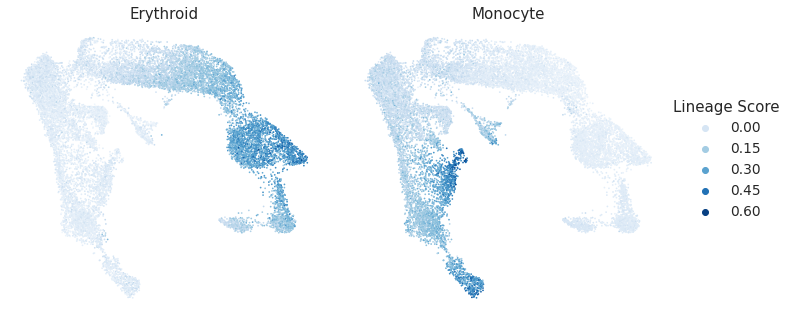

In [2028]:
df = donorB_all_NetworkIDs.obs[['Erythroid_lineage','Monocyte_lineage']]
df['UMAP1'] = donorB_all_NetworkIDs.obsm['X_umap'][:,0]
df['UMAP2'] = donorB_all_NetworkIDs.obsm['X_umap'][:,1]
g = sns.relplot(data=df.melt(id_vars=['UMAP1','UMAP2'],var_name='Lineage',value_name='Lineage Score'),
            x='UMAP1',
            y='UMAP2',
            hue='Lineage Score',
            col='Lineage',
            edgecolor='none',
            linewidth=0,
            s=3,
            palette='Blues',
            rasterized=True)
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    ax.set(title=study.split('_')[0])

g.savefig('/home/bharris/pseudotime/figures/cross_species/human_lineage_scores_umap.pdf',
          transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


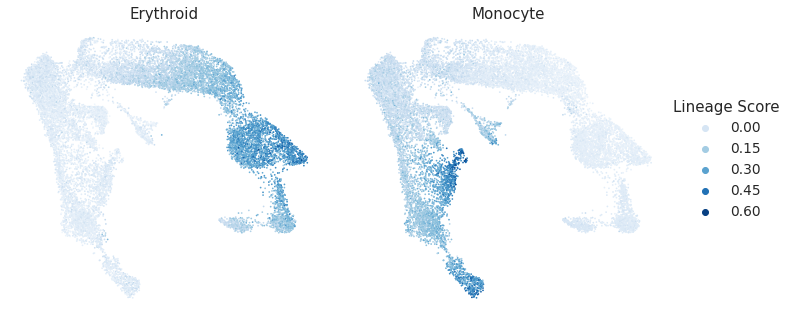

In [2073]:
df = donorB_all_NetworkIDs.obs[['Erythroid_lineage','Monocyte_lineage']]
df['UMAP1'] = donorB_all_NetworkIDs.obsm['X_umap'][:,0]
df['UMAP2'] = donorB_all_NetworkIDs.obsm['X_umap'][:,1]
g = sns.relplot(data=df.melt(id_vars=['UMAP1','UMAP2'],var_name='Lineage',value_name='Lineage Score'),
            x='UMAP1',
            y='UMAP2',
            hue='Lineage Score',
            col='Lineage',
            edgecolor='none',
            linewidth=0,
            s=3,
            palette='Blues',
            rasterized=True)
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    ax.set(title=study.split('_')[0])

g.savefig('/home/bharris/pseudotime/figures/cross_species/human_lineage_scores_umap_blues.pdf',
          transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


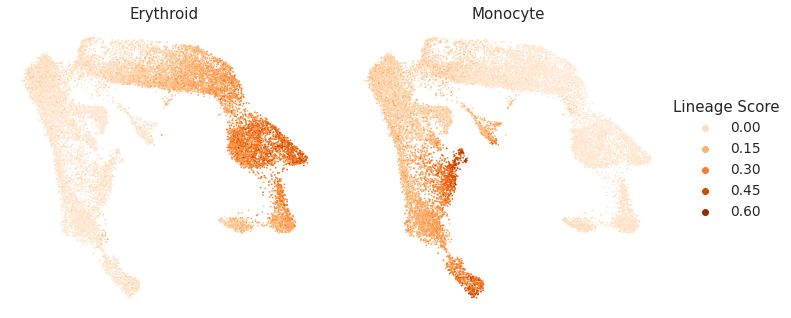

In [2074]:
df = donorB_all_NetworkIDs.obs[['Erythroid_lineage','Monocyte_lineage']]
df['UMAP1'] = donorB_all_NetworkIDs.obsm['X_umap'][:,0]
df['UMAP2'] = donorB_all_NetworkIDs.obsm['X_umap'][:,1]
g = sns.relplot(data=df.melt(id_vars=['UMAP1','UMAP2'],var_name='Lineage',value_name='Lineage Score'),
            x='UMAP1',
            y='UMAP2',
            hue='Lineage Score',
            col='Lineage',
            edgecolor='none',
            linewidth=0,
            s=3,
            palette='Oranges',
            rasterized=True)
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    ax.set(title=study.split('_')[0])

g.savefig('/home/bharris/pseudotime/figures/cross_species/human_lineage_scores_umap_orange.pdf',
          transparent=True)

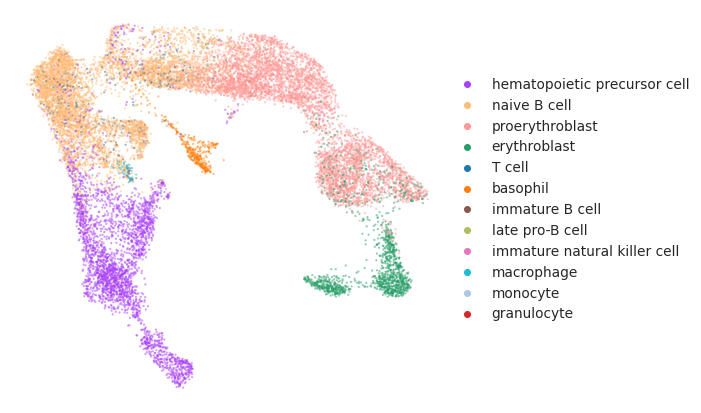

In [1646]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=donorB_all.obsm['X_umap'][:,0],
            y=donorB_all.obsm['X_umap'][:,1],
               hue=donorB_all_NetworkIDs.obs[top_markers.columns].idxmax(axis=1),
               edgecolor='none',
               palette=ct_pal,
               s=5,
               alpha=.5,
               ax=ax)
ax.legend(loc=(1,.2),
          frameon=False)
ax.axis('off')
plt.tight_layout()
plt.show()

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


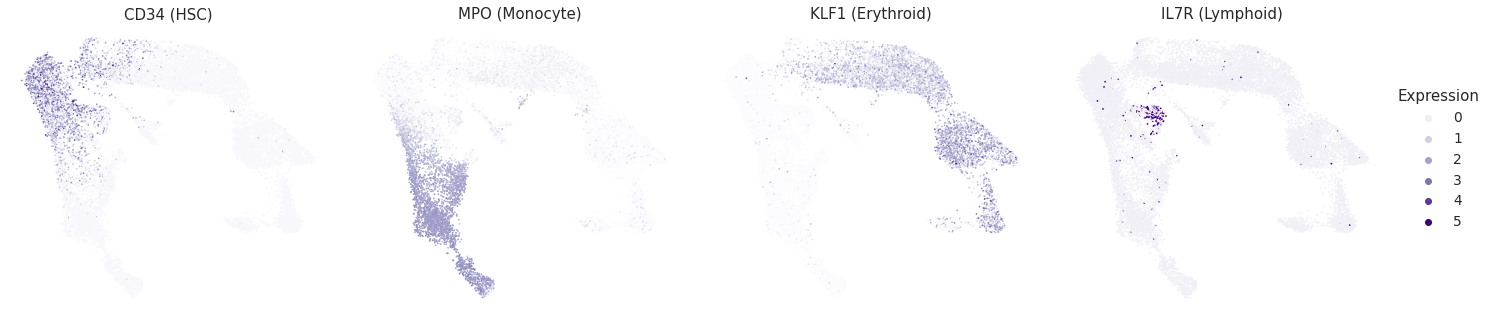

In [2072]:
known_human_expression = sc.pp.scale(donorB_all[:,['CD34','MPO','KLF1','IL7R']], copy=True).to_df().apply(stats.zscore)
known_human_expression.values[known_human_expression.values>5] = 5
known_human_expression['UMAP1'] = donorB_all.obsm['X_umap'][:,0]
known_human_expression['UMAP2'] = donorB_all.obsm['X_umap'][:,1]
g = sns.relplot(data=known_human_expression.melt(id_vars=['UMAP1','UMAP2'],var_name='Gene',value_name='Expression'),
            x='UMAP1',
            y='UMAP2',
            hue='Expression',
            col='Gene',
            edgecolor='none',
            linewidth=0,
            s=3,
            palette='Purples',
            rasterized=True,
            vmax=10,
            col_wrap=4)
title_dict = dict(zip(['CD34',
                       'MPO',
                       'KLF1',
                       'IL7R'],
                      ['CD34 (HSC)',
                       'MPO (Monocyte)',
                       'KLF1 (Erythroid)',
                       'IL7R (Lymphoid)']))

for ax, gene in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    ax.set(title=title_dict[gene])
g.savefig('/home/bharris/pseudotime/figures/cross_species/humap_umap_known_markers_purples.pdf',
            transparent=True)

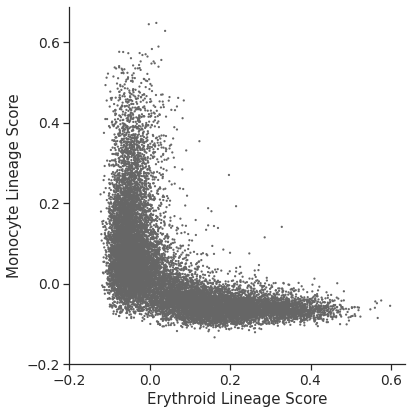

In [2003]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=donorB_all_NetworkIDs.obs,
                x='Erythroid_lineage',
                y='Monocyte_lineage',
                color='.4',
                edgecolor='none',
                linewidth=0,
                s=5,
                rasterized=True,
                ax=ax)
ax.set(aspect='equal',
       xlabel='Erythroid Lineage Score',
       ylabel='Monocyte Lineage Score')
ax.set_yticks(ax.get_yticks()[::2])
ax.set_xticks(ax.get_yticks())

plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/cross_species/human_orthogonal_scores.pdf',
            transparent=True)

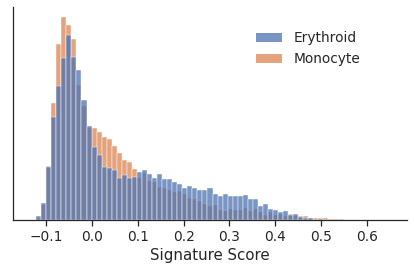

In [1348]:
ax = sns.histplot(data=donorB_all_NetworkIDs.obs[['Erythroid_lineage',
                                                   'Monocyte_lineage']].rename(columns={'Erythroid_lineage':'Erythroid',
                                                                                        'Monocyte_lineage':'Monocyte'}))
move_legend(ax, (.6,.7),frameon=False)
ax.set(yticks=[],ylabel='',xlabel='Signature Score')
ax.yaxis.set_visible(False) 
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/cross_species/human_lineage_scores_hist.pdf',
            transparent=True)